## Урок 8. Домашнее задание

Попробуем решить задачу классификации с помощью нейронных сетей для датасета __cars196__. Для начала импортируем необходимые библиотеки:

In [1]:
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Add, RandomFlip, RandomRotation
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from matplotlib import pyplot as plt
from keras.layers import Input, Concatenate
from tensorflow.keras.utils import plot_model
from keras.models import Model
from scipy.io import loadmat
from tensorflow.keras.preprocessing import image

Загрузить датасет через tfds у меня не получилось, потому что, насколько я понимаю, до сих пор не исправлена ссылка на датасет: https://github.com/tensorflow/datasets/issues/3219

In [2]:
# (train_ds, test_ds), metadata = tfds.load('cars196', 
#                                           split=['train[:40%]', 'test[:30%]'], 
#                                           with_info=True)

Соберем датасет вручную с помощью ссылок с официального сайта:
https://ai.stanford.edu/~jkrause/cars/car_dataset.html

In [3]:
dm = tfds.download.DownloadManager(download_dir='/tmp')

data_dirs = dm.download_and_extract({
    'train': 'http://ai.stanford.edu/~jkrause/car196/cars_train.tgz',
    'test':'http://ai.stanford.edu/~jkrause/car196/cars_test.tgz',
    'meta': 'https://ai.stanford.edu/%7Ejkrause/cars/car_devkit.tgz',
    'test_annos': 'http://ai.stanford.edu/~jkrause/car196/cars_test_annos_withlabels.mat'})

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Для начала построим словари для обучающей и тестовой выборок, которые будут содержать номер класса для каждого изображения:

In [4]:
cars_train_annos = loadmat(data_dirs['meta']+'/devkit/cars_train_annos.mat')
cars_test_annos = loadmat(data_dirs['test_annos'])

In [5]:
dic = {}
for i in range(len(cars_train_annos['annotations'][0])):
  dic[cars_train_annos['annotations'][0][i][5][0]] = cars_train_annos['annotations'][0][i][4][0][0]

test_dic = {}
for i in range(len(cars_test_annos['annotations'][0])):
  test_dic[cars_test_annos['annotations'][0][i][5][0]] = cars_test_annos['annotations'][0][i][4][0][0]

Теперь сформируем сами датасеты и поставим в соответствие каждому изображению метку класса. Так как изображения имеют разные разрешения, произведет одновременно приведение их к единому формату.

In [6]:
PATH_train = data_dirs['train']+'/cars_train/'
PATH_test = data_dirs['test']+'/cars_test/'

imag_label = os.listdir(PATH_train)
test_imag_label = os.listdir(PATH_test)

In [7]:
image_size = (128,128)

X_train = []
y_train = []
for i_name in imag_label[:5000]:
  img = image.load_img(PATH_train+i_name,target_size=image_size)
  X_train.append(np.asarray(img)/255.)
  y_train.append(dic[i_name]-1)


X_test = []
y_test = []
for i_name in test_imag_label[:3000]:
  img = image.load_img(PATH_test+i_name,target_size=image_size)
  X_test.append(np.asarray(img)/255.)
  y_test.append(test_dic[i_name]-1)

Создадим словарь, который будет содержать сопоставление номеров классов и их описаний:

In [8]:
cars_train_meta = loadmat(data_dirs['meta']+'/devkit/cars_meta.mat')['class_names'][0]
cars_class_names = []

for i in range(len(cars_train_meta)):
  cars_class_names.append(cars_train_meta[i][0])

Посмотрим на небольшую выборку автомобилей из обучающего датасета с названиями классов:

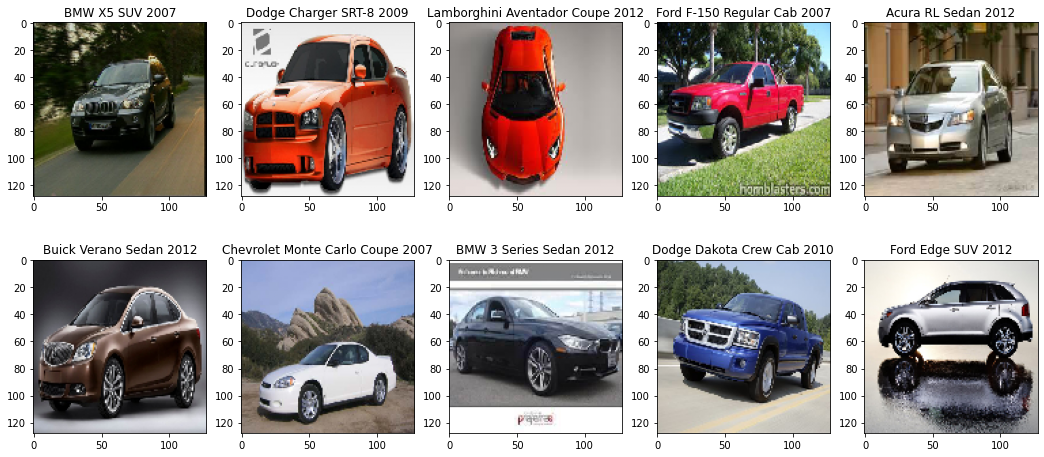

In [9]:
cols = 5
rows = 2
shift = 30

fig, axes = plt.subplots(rows, cols, figsize=(18, 8))

for i in range(rows*cols):
  axes[i // cols, i - cols * (i // cols)].imshow(X_train[shift + i])
  axes[i // cols, i - cols * (i // cols)].title.set_text(cars_class_names[y_train[shift + i]])

plt.show()

Посмотрим на распределение изображений по классам:

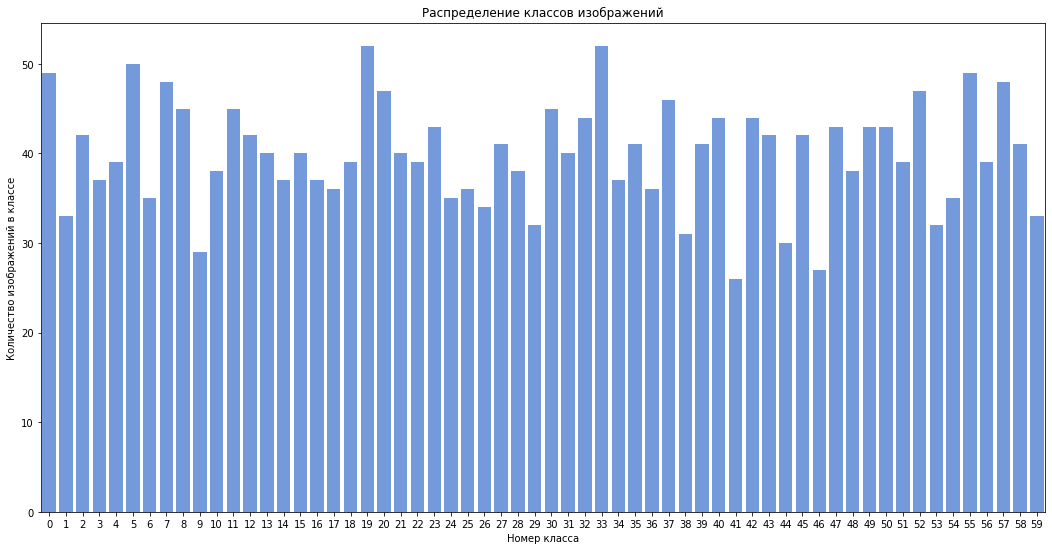

In [10]:
unique, counts = np.unique(y_test + y_train, return_counts=True)

plt.figure(figsize=(18,9))
sns.barplot(x=unique[:60], y=counts[:60], color='cornflowerblue')
plt.title('Распределение классов изображений')
plt.ylabel('Количество изображений в классе')
plt.xlabel('Номер класса')
plt.show()

In [11]:
num_classes = len(unique)
num_classes

196

In [12]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [13]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [14]:
X_train[1].shape

(128, 128, 3)

In [15]:
datagen = ImageDataGenerator(
  featurewise_center=False,
  samplewise_center=False,
  featurewise_std_normalization=False,
  samplewise_std_normalization=False,
  zca_whitening=False, 
  zca_epsilon=1e-06, 
  rotation_range=10, 
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0., 
  zoom_range=0.1, 
  channel_shift_range=0.1,
  fill_mode='nearest',
  cval=0.1,
  horizontal_flip=True,
  vertical_flip=False,
  rescale=None,
  preprocessing_function=None,
  data_format=None,
  validation_split=0.0)

In [16]:
inputs = Input(shape=(128,128,3)) 

x = Conv2D(64,3, activation='relu', padding='same', name='conv_1')(inputs)
x = BatchNormalization()(x)
x = Conv2D(64,3, activation='relu', padding='same', name='conv_2')(x) 
# можно добавлять блоки сверток, но следует следить за размером
# padding ='valid' - размер выходов постепенно уменьшается 
#ResNet - блок
x_shortcut = x # +x
x = Conv2D(64,3, activation='relu', padding='same',name='conv_31')(x) # H
x = Conv2D(64,3, activation='relu', padding='same',name='conv_41')(x) 
x = Add()([x, x_shortcut]) # F = H +x
x = BatchNormalization()(x)
# нелинейная трансформация и уменьшение размера в 2 раза
x = MaxPooling2D()(x) 
x_shortcut = x
x = Conv2D(64,3, activation='relu', padding='same', name='conv_32')(x) 
x = Conv2D(64,3, activation='relu', padding='same', name='conv_42')(x)
x = Add()([x, x_shortcut])
x = BatchNormalization()(x)
x_shortcut = x

x = Conv2D(64,3, activation='relu', padding='same', name='conv_3')(x) 
x = Conv2D(64,3, activation='relu',  padding='same', name='conv_4')(x)
x = Add()([x, x_shortcut])  
x = MaxPooling2D((2,2),(2,2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu', name='dense_1')(x) 
 

outputs = Dense(num_classes,activation='softmax' ,name='predictions')(x) 
model1 = Model(inputs=inputs, outputs=outputs)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv_1[0][0]']                 
 alization)                     )                                                             

In [17]:
model1.compile(optimizer='SGD', 
                    loss=keras.losses.CategoricalCrossentropy(),
                    metrics=['accuracy'])

In [18]:
batch_size=196
epochs=15

hist = model1.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                  epochs = epochs, validation_data=(X_test, y_test))

# проверка работы обученной модели
print('Test')
scores = model1.evaluate(X_test, y_test, verbose=1)

Epoch 1/15
26/26 [==============================] - 85s 3s/step - loss: 5.4059 - accuracy: 0.0034 - val_loss: 5.3192 - val_accuracy: 0.0067
Epoch 2/15
26/26 [==============================] - 60s 2s/step - loss: 5.2754 - accuracy: 0.0068 - val_loss: 5.5742 - val_accuracy: 0.0053
Epoch 3/15
26/26 [==============================] - 59s 2s/step - loss: 5.2614 - accuracy: 0.0092 - val_loss: 5.9195 - val_accuracy: 0.0053
Epoch 4/15
26/26 [==============================] - 59s 2s/step - loss: 5.2424 - accuracy: 0.0088 - val_loss: 6.3706 - val_accuracy: 0.0050
Epoch 5/15
26/26 [==============================] - 59s 2s/step - loss: 5.2235 - accuracy: 0.0156 - val_loss: 6.6112 - val_accuracy: 0.0053
Epoch 6/15
26/26 [==============================] - 59s 2s/step - loss: 5.2089 - accuracy: 0.0146 - val_loss: 6.8633 - val_accuracy: 0.0047
Epoch 7/15
26/26 [==============================] - 59s 2s/step - loss: 5.1813 - accuracy: 0.0178 - val_loss: 7.0695 - val_accuracy: 0.0053
Epoch 8/15
26/26 [==